# Proyek Akhir: Menyelesaikan Permasalahan Perusahaan Edutech

- Nama: Rehan Athallah Azhar
- Email: Azharrehan502@gmail.com
- Id Dicoding: rehan_azhar

**Latar Belakang**

  Jaya Jaya Institut merupakan salah satu institusi pendidikan perguruan yang telah berdiri sejak tahun 2000. Hingga saat ini ia telah mencetak banyak lulusan dengan reputasi yang sangat baik. Akan tetapi, terdapat banyak juga siswa yang tidak menyelesaikan pendidikannya alias dropout.

  Jumlah dropout yang tinggi ini tentunya menjadi salah satu masalah yang besar untuk sebuah institusi pendidikan. Oleh karena itu, Jaya Jaya Institut ingin mendeteksi secepat mungkin siswa yang mungkin akan melakukan dropout sehingga dapat diberi bimbingan khusus.


**Pertanyaan Bisnis**
1. Berapa proporsi mahasiswa yang keluar (drop out) dibandingkan total mahasiswa?
2. Bagaimana distribusi status mahasiswa berdasarkan berbagai fitur?
3. Faktor apa saja yang paling mempengaruhi kelulusan/dropout mahasiswa?

**Tujuan**
1. Mengidentifikasi besaran proporsi mahasiswa yg drop out
2. Distribusi status mahasiswa berdasarkan berbagai fitur
3. Faktor yang paling mempengaruhi kelulusan/dropout mahasiswa




## Persiapan

### Menyiapkan library yang dibutuhkan

In [1]:
import numpy as np
import re

import os
import joblib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.ml import Pipeline
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sqlalchemy import create_engine

import warnings
warnings.filterwarnings("ignore")

### Menyiapkan data yang akan digunakan

In [2]:
df = pd.read_csv("./data.csv", sep=";")

In [3]:
df.head(5)

,Marital_status,Application_mode,Application_order,Course,Daytime_evening_attendance,Previous_qualification,Previous_qualification_grade,Nacionality,Mothers_qualification,Fathers_qualification,...,Curricular_units_2nd_sem_credited,Curricular_units_2nd_sem_enrolled,Curricular_units_2nd_sem_evaluations,Curricular_units_2nd_sem_approved,Curricular_units_2nd_sem_grade,Curricular_units_2nd_sem_without_evaluations,Unemployment_rate,Inflation_rate,GDP,Status
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


## Data Understanding

In [4]:
# Check null values
print(df.isnull().sum())

Marital_status                                  0
Application_mode                                0
Application_order                               0
Course                                          0
Daytime_evening_attendance                      0
Previous_qualification                          0
Previous_qualification_grade                    0
Nacionality                                     0
Mothers_qualification                           0
Fathers_qualification                           0
Mothers_occupation                              0
Fathers_occupation                              0
Admission_grade                                 0
Displaced                                       0
Educational_special_needs                       0
Debtor                                          0
Tuition_fees_up_to_date                         0
Gender                                          0
Scholarship_holder                              0
Age_at_enrollment                               0


In [5]:
# Check duplicate values
count_duplicate = df.duplicated().sum()
print("Duplicate rows:", count_duplicate)

Duplicate rows: 0


In [6]:
df.describe()

,Marital_status,Application_mode,Application_order,Course,Daytime_evening_attendance,Previous_qualification,Previous_qualification_grade,Nacionality,Mothers_qualification,Fathers_qualification,...,Curricular_units_1st_sem_without_evaluations,Curricular_units_2nd_sem_credited,Curricular_units_2nd_sem_enrolled,Curricular_units_2nd_sem_evaluations,Curricular_units_2nd_sem_approved,Curricular_units_2nd_sem_grade,Curricular_units_2nd_sem_without_evaluations,Unemployment_rate,Inflation_rate,GDP
count,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,...,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000
mean,1.178571,18.669078,1.727848,8856.642631,0.890823,4.577758,132.613314,1.873192,19.561935,22.275316,...,0.137658,0.541817,6.232143,8.063291,4.435805,10.230206,0.150316,11.566139,1.228029,0.001969
std,0.605747,17.484682,1.313793,2063.566416,0.311897,10.216592,13.188332,6.914514,15.603186,15.343108,...,0.690880,1.918546,2.195951,3.947951,3.014764,5.210808,0.753774,2.663850,1.382711,2.269935
min,1.000000,1.000000,0.000000,33.000000,0.000000,1.000000,95.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.600000,-0.800000,-4.060000
25%,1.000000,1.000000,1.000000,9085.000000,1.000000,1.000000,125.000000,1.000000,2.000000,3.000000,...,0.000000,0.000000,5.000000,6.000000,2.000000,10.750000,0.000000,9.400000,0.300000,-1.700000
50%,1.000000,17.000000,1.000000,9238.000000,1.000000,1.000000,133.100000,1.000000,19.000000,19.000000,...,0.000000,0.000000,6.000000,8.000000,5.000000,12.200000,0.000000,11.100000,1.400000,0.320000
75%,1.000000,39.000000,2.000000,9556.000000,1.000000,1.000000,140.000000,1.000000,37.000000,37.000000,...,0.000000,0.000000,7.000000,10.000000,6.000000,13.333333,0.000000,13.900000,2.600000,1.790000
max,6.000000,57.000000,9.000000,9991.000000,1.000000,43.000000,190.000000,109.000000,44.000000,44.000000,...,12.000000,19.000000,23.000000,33.000000,20.000000,18.571429,12.000000,16.200000,3.700000,3.510000


In [7]:
# Step 1: Assume 0 as missing value in grade columns
cols_with_zero_invalid = [
    "Previous_qualification_grade",
    "Admission_grade",
    "Curricular_units_1st_sem_grade",
    "Curricular_units_2nd_sem_grade"
]

df[cols_with_zero_invalid] = df[cols_with_zero_invalid].replace(0, np.nan)

In [8]:
# Step 2: Fix negative values
df['Unemployment_rate'] = df['Unemployment_rate'].apply(lambda x: np.nan if x < 0 else x)
df['Inflation_rate'] = df['Inflation_rate'].apply(lambda x: np.nan if x < 0 else x)

In [9]:
# Step 3: Trim spaces in Status column
df['Status'] = df['Status'].str.strip()

In [10]:
# Missing value count
missing_count = df.isnull().sum()
print("Missing values:\n", missing_count)

# Missing value percentage
missing_percent = df.isnull().mean() * 100
print("Missing value percentage:\n", missing_percent)

Missing values:
 Marital_status                                    0
Application_mode                                  0
Application_order                                 0
Course                                            0
Daytime_evening_attendance                        0
Previous_qualification                            0
Previous_qualification_grade                      0
Nacionality                                       0
Mothers_qualification                             0
Fathers_qualification                             0
Mothers_occupation                                0
Fathers_occupation                                0
Admission_grade                                   0
Displaced                                         0
Educational_special_needs                         0
Debtor                                            0
Tuition_fees_up_to_date                           0
Gender                                            0
Scholarship_holder                             

In [11]:
df.describe()

,Marital_status,Application_mode,Application_order,Course,Daytime_evening_attendance,Previous_qualification,Previous_qualification_grade,Nacionality,Mothers_qualification,Fathers_qualification,...,Curricular_units_1st_sem_without_evaluations,Curricular_units_2nd_sem_credited,Curricular_units_2nd_sem_enrolled,Curricular_units_2nd_sem_evaluations,Curricular_units_2nd_sem_approved,Curricular_units_2nd_sem_grade,Curricular_units_2nd_sem_without_evaluations,Unemployment_rate,Inflation_rate,GDP
count,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,...,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,3554.000000,4424.000000,4424.000000,3501.000000,4424.000000
mean,1.178571,18.669078,1.727848,8856.642631,0.890823,4.577758,132.613314,1.873192,19.561935,22.275316,...,0.137658,0.541817,6.232143,8.063291,4.435805,12.734505,0.150316,11.566139,1.706998,0.001969
std,0.605747,17.484682,1.313793,2063.566416,0.311897,10.216592,13.188332,6.914514,15.603186,15.343108,...,0.690880,1.918546,2.195951,3.947951,3.014764,1.378839,0.753774,2.663850,1.140218,2.269935
min,1.000000,1.000000,0.000000,33.000000,0.000000,1.000000,95.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,0.000000,7.600000,0.300000,-4.060000
25%,1.000000,1.000000,1.000000,9085.000000,1.000000,1.000000,125.000000,1.000000,2.000000,3.000000,...,0.000000,0.000000,5.000000,6.000000,2.000000,11.714286,0.000000,9.400000,0.600000,-1.700000
50%,1.000000,17.000000,1.000000,9238.000000,1.000000,1.000000,133.100000,1.000000,19.000000,19.000000,...,0.000000,0.000000,6.000000,8.000000,5.000000,12.666667,0.000000,11.100000,1.400000,0.320000
75%,1.000000,39.000000,2.000000,9556.000000,1.000000,1.000000,140.000000,1.000000,37.000000,37.000000,...,0.000000,0.000000,7.000000,10.000000,6.000000,13.666667,0.000000,13.900000,2.600000,1.790000
max,6.000000,57.000000,9.000000,9991.000000,1.000000,43.000000,190.000000,109.000000,44.000000,44.000000,...,12.000000,19.000000,23.000000,33.000000,20.000000,18.571429,12.000000,16.200000,3.700000,3.510000


In [12]:
# Drop rows where Inflation_rate is missing
df = df.dropna(subset=['Inflation_rate'])

In [13]:
# ffill + bfill for specific columns grouped by Course
missing_columns = [
    'Curricular_units_1st_sem_grade',
    'Curricular_units_2nd_sem_grade'
]
for col in missing_columns:
    df[col] = df.groupby('Course')[col].transform(lambda x: x.ffill().bfill())

In [14]:
# Outlier Handling

numerical_cols = [
    'Application_order', 'Previous_qualification_grade', 'Admission_grade', 'Age_at_enrollment',
    'Curricular_units_1st_sem_credited', 'Curricular_units_1st_sem_enrolled',
    'Curricular_units_1st_sem_evaluations', 'Curricular_units_1st_sem_approved',
    'Curricular_units_1st_sem_grade', 'Curricular_units_1st_sem_without_evaluations',
    'Curricular_units_2nd_sem_credited', 'Curricular_units_2nd_sem_enrolled',
    'Curricular_units_2nd_sem_evaluations', 'Curricular_units_2nd_sem_approved',
    'Curricular_units_2nd_sem_grade', 'Curricular_units_2nd_sem_without_evaluations',
    'Unemployment_rate', 'Inflation_rate', 'GDP'
]

def cap_outliers_iqr(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    df[column] = np.where(df[column] < lower, lower,
                          np.where(df[column] > upper, upper, df[column]))
    return df

for col in numerical_cols:
    df = cap_outliers_iqr(df, col)


In [15]:
# Final cleaned data
cleaned_df = df.copy()
cleaned_df.head()

,Marital_status,Application_mode,Application_order,Course,Daytime_evening_attendance,Previous_qualification,Previous_qualification_grade,Nacionality,Mothers_qualification,Fathers_qualification,...,Curricular_units_2nd_sem_credited,Curricular_units_2nd_sem_enrolled,Curricular_units_2nd_sem_evaluations,Curricular_units_2nd_sem_approved,Curricular_units_2nd_sem_grade,Curricular_units_2nd_sem_without_evaluations,Unemployment_rate,Inflation_rate,GDP,Status
0,1,17,3.5,171,1,1,122.0,1,19,12,...,0.0,2.0,0.0,0.0,13.555556,0.0,10.8,1.4,1.74,Dropout
2,1,1,3.5,9070,1,1,122.0,1,37,37,...,0.0,6.0,0.0,0.0,13.400000,0.0,10.8,1.4,1.74,Dropout
5,2,39,1.0,9991,0,19,133.1,1,37,37,...,0.0,5.0,16.0,5.0,11.500000,0.0,16.2,0.3,-0.92,Graduate
6,1,1,1.0,9500,1,1,142.0,1,19,38,...,0.0,8.0,8.0,8.0,14.345000,0.0,15.5,2.8,-4.06,Graduate
7,1,18,3.5,9254,1,1,119.0,1,37,37,...,0.0,5.0,5.0,0.0,11.000000,0.0,15.5,2.8,-4.06,Dropout


**Explanation**


1. **Why Empty data in Inflation_rate is deleted?**

  Inflation_rate is not student-specific data; it is a macroeconomic condition of the country.

  We don’t know if the Inflation_rate applies to:
  - The year the student enrolled,
  - The year of graduation,
  - Or the current year.

  Since there is no clear relationship between Inflation_rate and student-related variables, it’s better to remove it to avoid contaminating the model or analysis.

  Rather than risking incorrect imputation or interpretation, it’s safer to discard it.

2. **Why continue with ffill & bfill for Curricular_units_1st_sem_grade and Curricular_units_2nd_sem_grade?**

  Both columns represent students' academic grades → It makes sense to perform imputation within a single course.

  We assume that students within the same course and cohort have similar grading patterns.

  Forward fill (ffill) and backward fill (bfill) are still applied, grouped by Course, to maintain academic validity.

### EDA

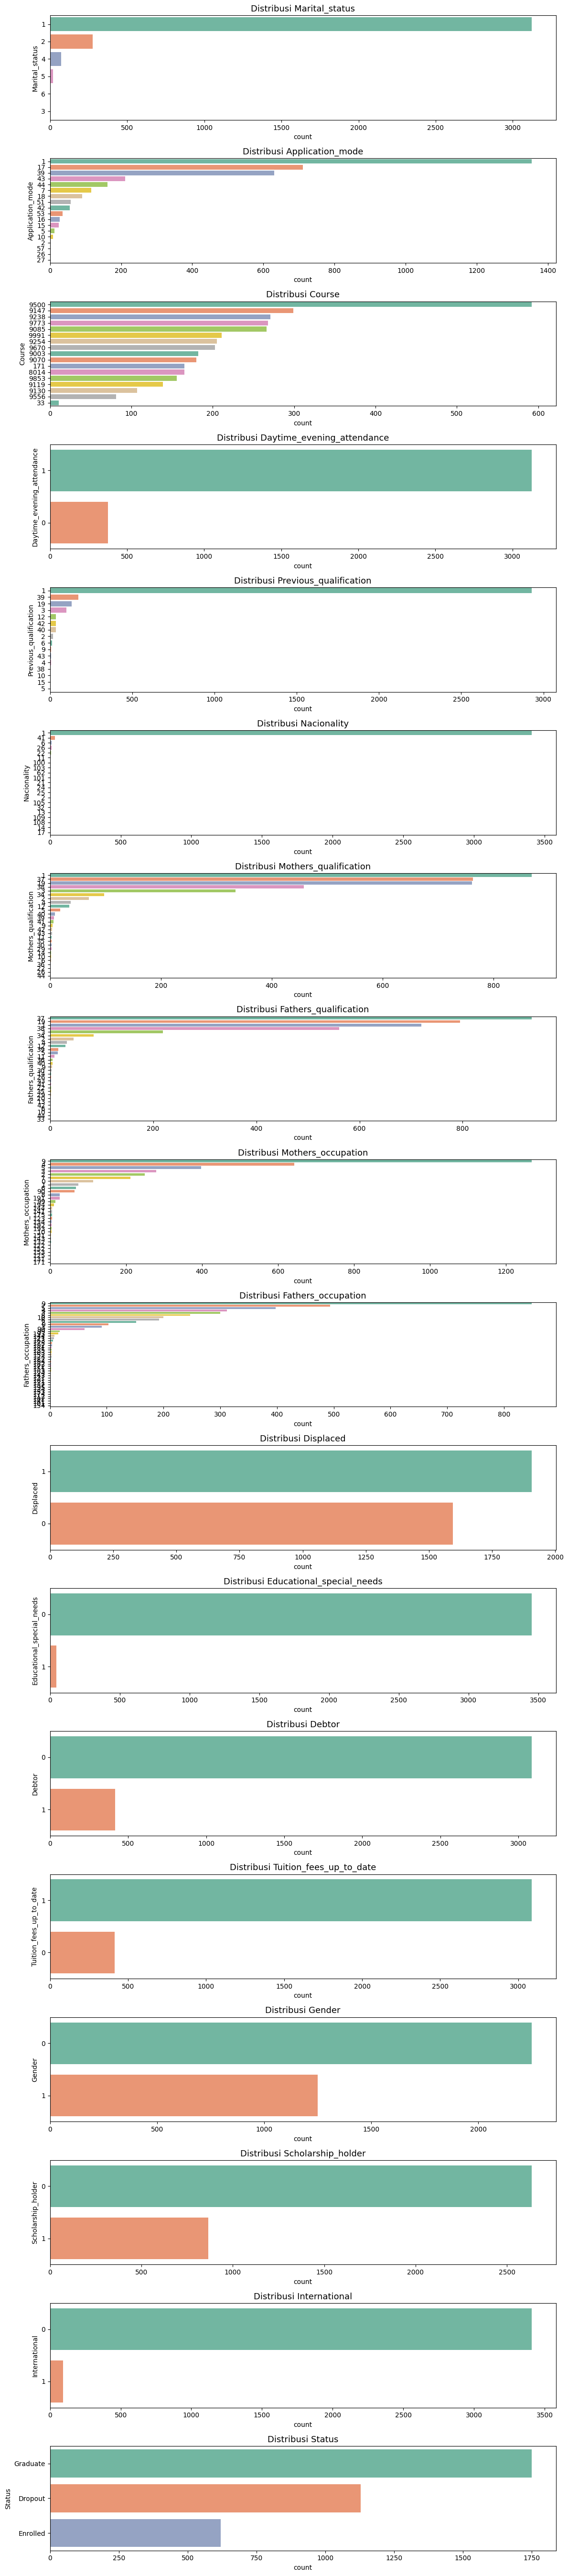

In [16]:
# Categorical coloumn list
categorical_cols = [
    'Marital_status', 'Application_mode', 'Course', 'Daytime_evening_attendance',
    'Previous_qualification', 'Nacionality', 'Mothers_qualification',
    'Fathers_qualification', 'Mothers_occupation', 'Fathers_occupation', 'Displaced',
    'Educational_special_needs', 'Debtor', 'Tuition_fees_up_to_date', 'Gender',
    'Scholarship_holder', 'International', 'Status'
]

fig, ax = plt.subplots(len(categorical_cols), 1, figsize=(12, 3 * len(categorical_cols)))

for i, col_name in enumerate(categorical_cols):
    sns.countplot(y=col_name, data=cleaned_df,
                  order=cleaned_df[col_name].value_counts().index,
                  ax=ax[i], palette="Set2")
    ax[i].set_title(f'Distribusi {col_name}', fontsize=13)
    ax[i].tick_params(axis='y', labelsize=10)

plt.tight_layout()
plt.show()

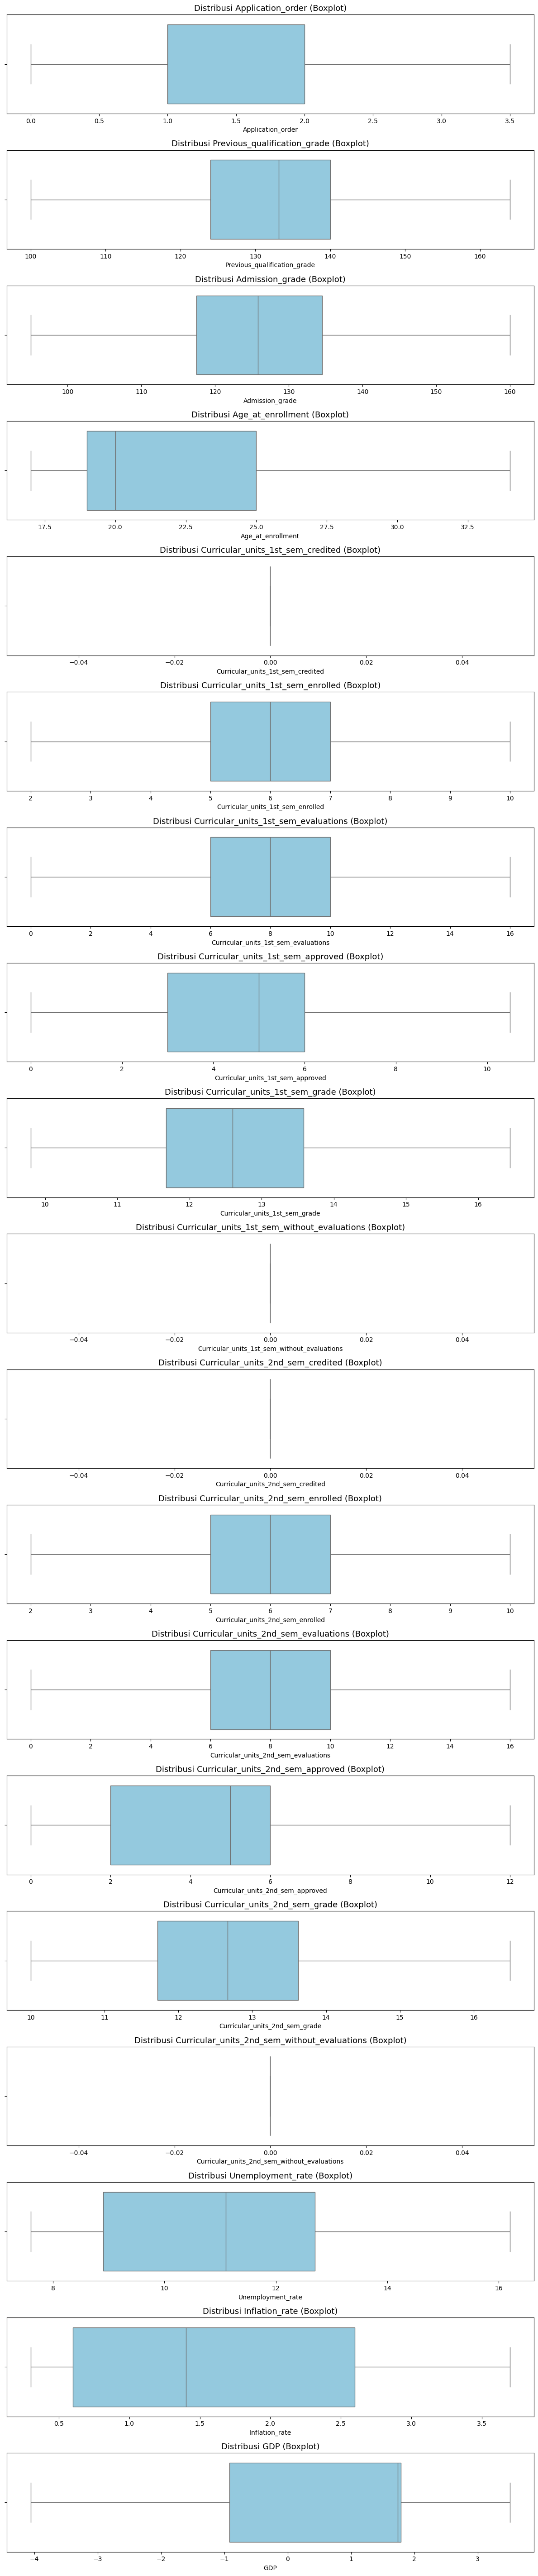

In [17]:
# Numerical coloumn list
fig, ax = plt.subplots(len(numerical_cols), 1, figsize=(12, 3 * len(numerical_cols)))

for i, col_name in enumerate(numerical_cols):
    sns.boxplot(x=cleaned_df[col_name], ax=ax[i], color="skyblue")
    ax[i].set_title(f'Distribusi {col_name} (Boxplot)', fontsize=13)
    ax[i].tick_params(axis='x', labelsize=10)

plt.tight_layout()
plt.show()


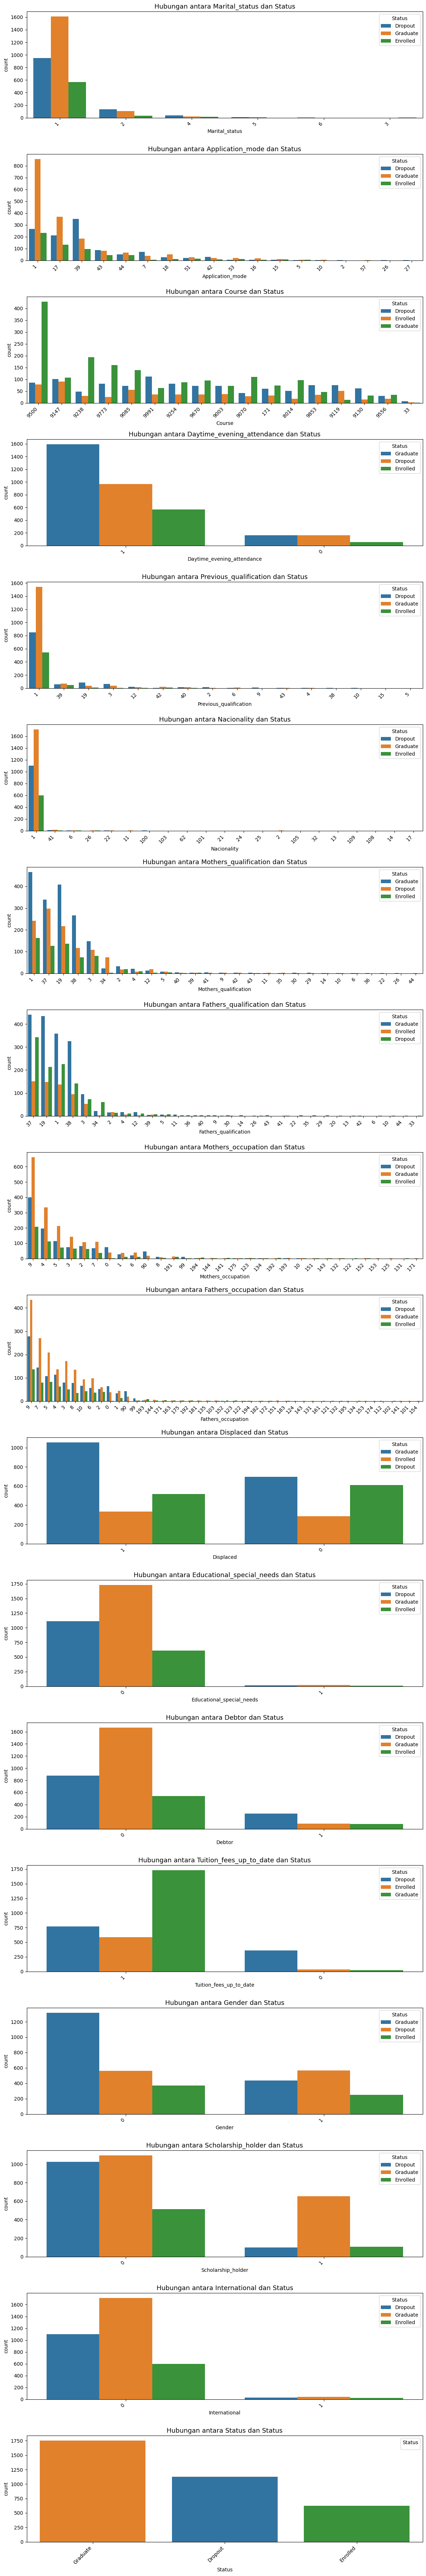

In [18]:
# Visualization of the relationship between categorical features and the 'Status' column
# categorical coloumn list (without 'Status', because it will be the target/hue)
fig, axes = plt.subplots(len(categorical_cols), 1, figsize=(12, 4 * len(categorical_cols)))

for i, col_name in enumerate(categorical_cols):
    sns.countplot(data=cleaned_df, x=col_name, hue='Status',
                  order=cleaned_df[col_name].value_counts().index,
                  ax=axes[i])
    axes[i].set_title(f'Hubungan antara {col_name} dan Status', fontsize=13)
    axes[i].tick_params(axis='x', labelrotation=45)
    axes[i].set_xticklabels(axes[i].get_xticklabels(), ha='right')
    axes[i].legend(title='Status', loc='upper right')

plt.tight_layout()
plt.show()

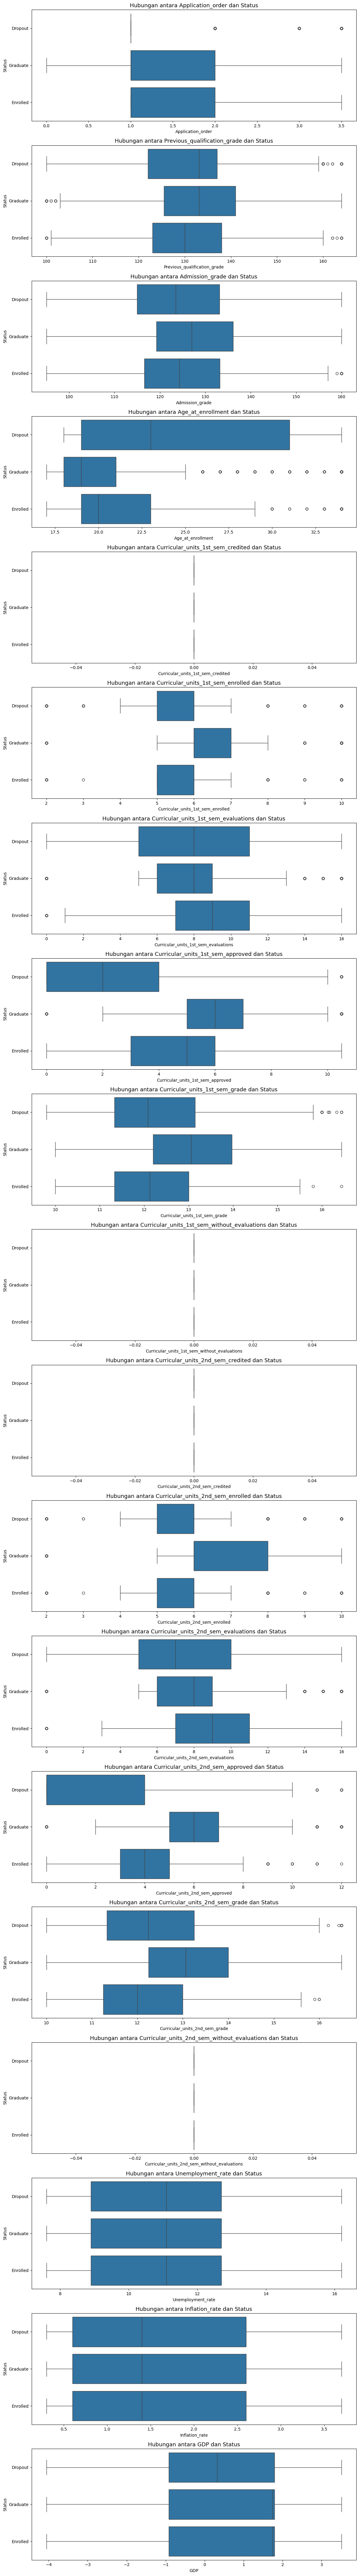

In [19]:
# Boxplot visualization of numerical feature relationship with target 'Status'
fig, axes = plt.subplots(len(numerical_cols), 1, figsize=(12, 4.5 * len(numerical_cols)))

for i, col_name in enumerate(numerical_cols):
    sns.boxplot(data=cleaned_df, x=col_name, y='Status', ax=axes[i])
    axes[i].set_title(f'Hubungan antara {col_name} dan Status', fontsize=13)
    axes[i].set_xlabel(col_name)
    axes[i].set_ylabel('Status')

plt.tight_layout()
plt.show()

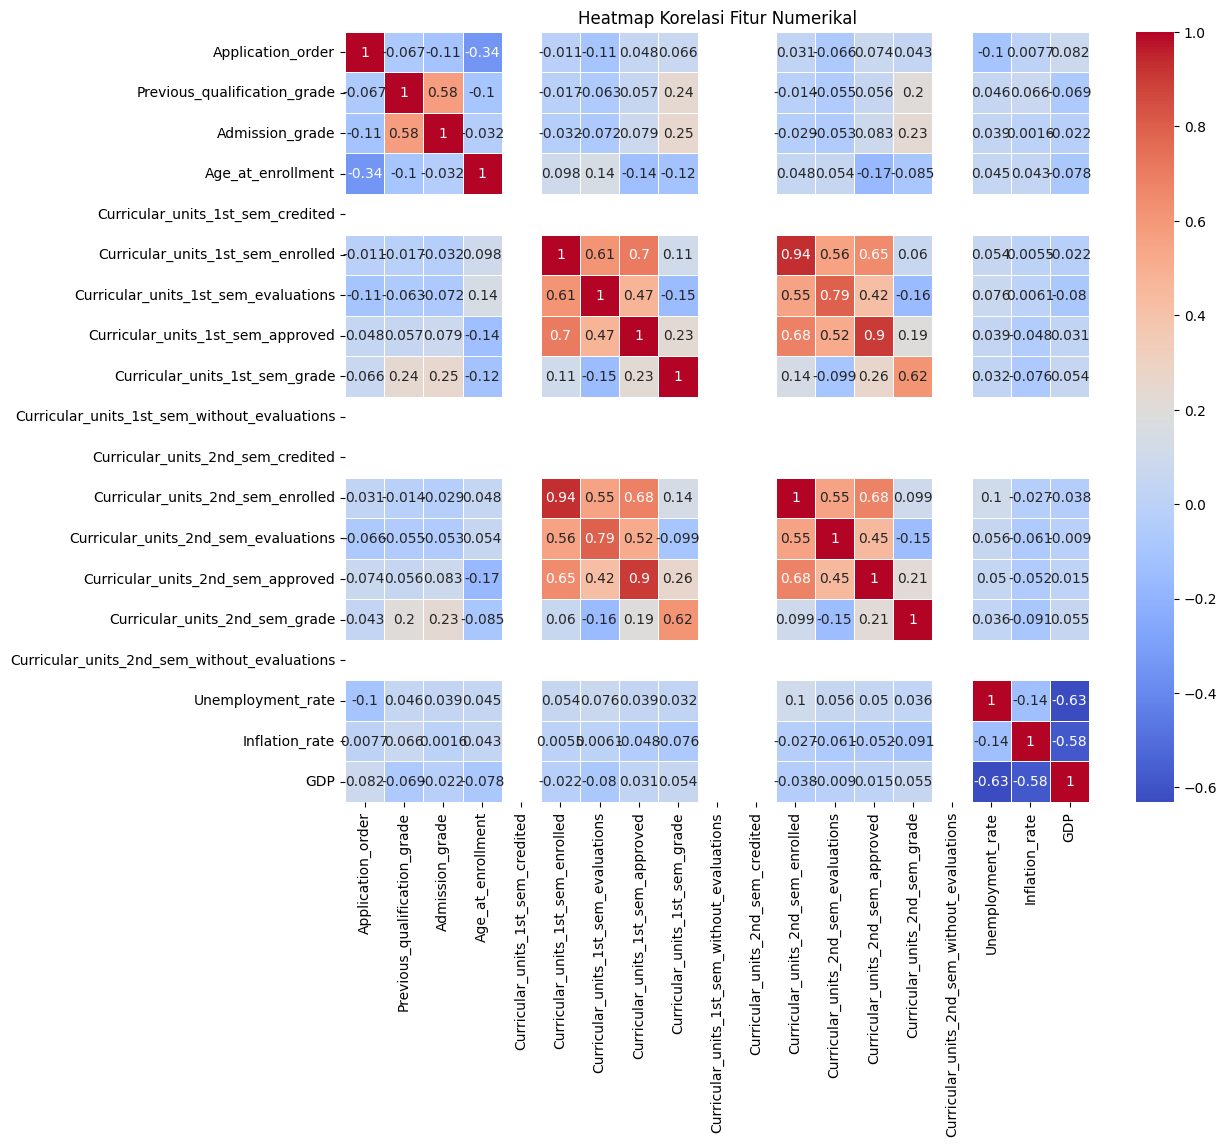

In [20]:
plt.figure(figsize=(12, 10))
sns.heatmap(cleaned_df[numerical_cols].corr(), annot=True, cmap="coolwarm", linewidths=0.5)
plt.title('Heatmap Korelasi Fitur Numerikal')
plt.show()

In [21]:
# URL = os.environ.get("DATABASE_URL")
# engine = create_engine(URL)

# data_pandas.columns = [col.lower() for col in data_pandas.columns]

# # export data to supabase
# data_pandas.to_sql('student', con=engine, if_exists='replace', index=False)

**Explanation**

**Gambar 1 – Histogram Distribusi untuk Setiap Kolom Kategorikal**
- Marital Status: Sebagian besar mahasiswa berstatus single, sangat sedikit yang married, divorced, atau lainnya. Ini normal mengingat mayoritas mahasiswa biasanya masih muda.

- Application Mode: Ada satu atau dua mode aplikasi yang dominan (kemungkinan besar 1st phase - general contingent), sedangkan mode lainnya jarang dipilih. Ini menunjukkan jalur masuk utama lebih banyak digunakan dibanding jalur-jalur alternatif.

- Course: Distribusi menunjukkan bahwa ada jurusan tertentu yang sangat populer dibanding jurusan lain. Misalnya Management atau Nursing mungkin memiliki lebih banyak mahasiswa.

- Previous Qualification, Mother's and Father's Qualification, Occupation, dan Nationality: Banyak mahasiswa berasal dari latar belakang pendidikan menengah (Secondary education). Sebagian besar orang tua mereka memiliki tingkat pendidikan menengah ke bawah, sedikit sekali dari tingkat master atau doktor.

- Daytime/Evening Attendance: Mayoritas mahasiswa menghadiri kelas di daytime.

- Gender: Rasio female dan male bisa jadi tidak seimbang, misalnya, Nursing biasanya lebih banyak female.

- Displaced, Scholarship Holder, Educational Special Needs: Mayoritas mahasiswa bukan displaced students, tidak memiliki kebutuhan khusus, namun cukup banyak yang menerima beasiswa.

**Insight:** Mayoritas mahasiswa masih muda, belum menikah, berasal dari jalur aplikasi umum, latar pendidikan menengah, dan mengambil kuliah di siang hari.

<br>

**Gambar 2 – Histogram Distribusi untuk Kolom Numerik**
- Age at Enrollment: Distribusi usia condensed di rentang 17–22 tahun, tipikal untuk mahasiswa S1. Ada sedikit ekor ke kanan (outlier >25 tahun).

- Previous Qualification Grade dan Admission Grade: Nilai masuk umumnya tinggi (>130 dari 200), tapi ada sebaran yang cukup besar. Ada mahasiswa yang masuk dengan nilai rendah, mungkin dari jalur alternatif.

- Curricular Units 1st Sem (credited/enrolled/evaluations/approved):

- Sebagian besar mahasiswa mengambil dan menyelesaikan 6-8 mata kuliah.

- Jumlah approved sedikit lebih rendah dari enrolled, wajar karena ada mahasiswa yang tidak lulus semua mata kuliah.

**Insight:** Mahasiswa tipikal berusia 17–22 tahun dengan performa akademik awal cukup baik, namun ada variasi pada jumlah mata kuliah yang diselesaikan.

<br>

**Gambar 3 – Hubungan antara Status (Dropout/Enrolled/Graduate) dan Setiap Kolom Kategorikal**
- **Target vs Final Situation** :
    - Mayoritas mahasiswa berakhir dengan status 'Drop-out'
    - Mahasiswa yang 'Graduate' lebih banyak dibandingkan dengan 'Enrolled'
- **Distribusi Berdasarkan Atribut Kategori** :
    - Banyak atribut kategori (seperti 'Mother's qualification', 'Father's qualification', dll.) menunjukkan bahwa sebagian besar mahasiswa berasal dari latar belakang pendidikan rendah hingga sedang
    - Beberapa fitur seperti Scholarship menunjukkan distribusi yang berat ke arah tidak menerima beasiswa
    - Debtor status dan Tuition fees up to date menunjukkan bahwa mahasiswa yang tidak punya utang dan membayar tepat waktu memiliki angka kelulusan yang lebih tinggi
- **Final Situation vs Academic Performance** :
    - Mahasiswa yang lulus (graduate) cenderung memiliki jumlah mata kuliah lulus dan evaluasi yang lebih tinggi di semester 1 dan 2
    - Ada hubungan kuat antara keberhasilan akademik awal dan hasil akhir studi

<br>

**Gambar 4 – Hubungan antara Status dan Setiap Kolom Numerik**
- **Admission Grade vs Final Situation** :
    - Mahasiswa yang lulus memiliki nilai masuk yang lebih tinggi dibandingkan dropout dan yang masih aktif (enrolled)
    - Ada penyimpangan (outlier) pada semua kategori, tapi median pada lulusan tetap lebih tinggi
- **Curricular Units Semester 1 dan 2** :
    - Mahasiswa yang drop-out memiliki nilai evaluasi dan jumlah mata kuliah yang disetujui lebih rendah di semester awal
    - Jumlah evaluasi tanpa nilai tinggi pada mahasiswa drop-out, mengindikasikan ketidakhadiran atau ketidakseriusan
    - Jumlah mata kuliah yang diambil tetapi tidak diselesaikan juga tinggi pada mahasiswa yang gagal

**Gambar 5 – Heatmap Korelasi**

- Korelasi tinggi :
    - Curricular_units_1st_sem_enrolled dan Curricular_units_1st_sem_credited
    - Curricular_units_1st_sem_credited dan Curricular_units_1st_sem_approved
    - Fitur-fitur semester 2 juga memiliki pola serupa
- Admission grade berkorelasi positif dengan nilai semester 1 dan 2, meskipun tidak sangat kuat (maks sekitar 0.59).
- GDP, Unemployment rate, dan Inflation rate tidak menunjukkan korelasi signifikan terhadap variabel akademik



**Kesimpulan Akhir**
1. Keberhasilan akademik awal (semester 1 dan 2) sangat berkaitan dengan kelulusan mahasiswa.

2. Faktor sosio-ekonomi seperti pendidikan orang tua, status utang, dan pembayaran biaya kuliah juga mempengaruhi hasil akhir studi.

3. Mahasiswa dengan nilai masuk tinggi dan performansi akademik baik sejak awal cenderung menyelesaikan studinya.

4. Fitur-fitur eksternal seperti GDP dan tingkat pengangguran tidak terlalu memengaruhi performa mahasiswa.


## Data Preparation / Preprocessing

In [22]:
# Split train-test
train_df, test_df = train_test_split(cleaned_df, test_size=0.2, random_state=42, stratify=cleaned_df['Status'])
print(f"Train count: {train_df.count()}")
print(f"Test count: {test_df.count()}")

Train count: Marital_status                                  2800
Application_mode                                2800
Application_order                               2800
Course                                          2800
Daytime_evening_attendance                      2800
Previous_qualification                          2800
Previous_qualification_grade                    2800
Nacionality                                     2800
Mothers_qualification                           2800
Fathers_qualification                           2800
Mothers_occupation                              2800
Fathers_occupation                              2800
Admission_grade                                 2800
Displaced                                       2800
Educational_special_needs                       2800
Debtor                                          2800
Tuition_fees_up_to_date                         2800
Gender                                          2800
Scholarship_holder               

In [23]:
# Undersampling

min_class = train_df['Status'].value_counts().min()
undersampled = []

for cls in train_df['Status'].unique():
    cls_df = train_df[train_df['Status'] == cls]
    undersampled.append(resample(cls_df, replace=False, n_samples=min_class, random_state=42))

undersampled_train_df = pd.concat(undersampled)

In [24]:
# Lowercase column names
undersampled_train_df.columns = undersampled_train_df.columns.str.lower()
test_df.columns = test_df.columns.str.lower()

In [25]:
# Implement OrdinalEncoder for all categories
categorical_cols_lower = [col.lower() for col in categorical_cols if col.lower() != 'status']
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# Fit and transform to train + test
X_train_cat = encoder.fit_transform(undersampled_train_df[categorical_cols_lower])
X_test_cat = encoder.transform(test_df[categorical_cols_lower])


In [26]:
# Scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_cat)
X_test_scaled = scaler.transform(X_test_cat)

In [27]:
pca1 = PCA(n_components=5)
pca2 = PCA(n_components=2)

X_train_pca1 = pca1.fit_transform(X_train_scaled)
X_train_pca2 = pca2.fit_transform(X_train_scaled)

# Combine features
import numpy as np
X_train_final = np.hstack([X_train_pca1, X_train_pca2])
y_train_final = undersampled_train_df['status']


## Modeling

In [28]:
# Decision Tree objective with Hyperopt Optimization
def objective_dt(params):
    clf = DecisionTreeClassifier(max_depth=int(params['max_depth']), random_state=42)
    clf.fit(X_train_final, y_train_final)
    acc = accuracy_score(y_train_final, clf.predict(X_train_final))
    return {'loss': -acc, 'status': STATUS_OK}

best_params_dt = fmin(
    fn=objective_dt,
    space={'max_depth': hp.quniform('max_depth', 2, 10, 1)},
    algo=tpe.suggest,
    max_evals=20,
    trials=Trials()
)

100%|██████████| 20/20 [00:00<00:00, 55.41trial/s, best loss: -0.6753856472166331]


In [29]:
dt_model = DecisionTreeClassifier(max_depth=int(best_params_dt['max_depth']), random_state=42)
dt_model.fit(X_train_scaled, y_train_final)

DecisionTreeClassifier(max_depth=9, random_state=42)

In [30]:
# Random Forest objective with Hyperopt Optimization
def objective_rf(params):
    clf = RandomForestClassifier(
        n_estimators=int(params['n_estimators']),
        max_depth=int(params['max_depth']),
        random_state=42
    )
    clf.fit(X_train_final, y_train_final)
    acc = accuracy_score(y_train_final, clf.predict(X_train_final))
    return {'loss': -acc, 'status': STATUS_OK}

best_params_rf = fmin(
    fn=objective_rf,
    space={
        'n_estimators': hp.quniform('n_estimators', 50, 150, 10),
        'max_depth': hp.quniform('max_depth', 3, 10, 1)
    },
    algo=tpe.suggest,
    max_evals=20,
    trials=Trials()
)

100%|██████████| 20/20 [00:08<00:00,  2.33trial/s, best loss: -0.8229376257545271]


In [31]:
# Final Pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=5)),
    ('rf', RandomForestClassifier(
        n_estimators=int(best_params_rf['n_estimators']),
        max_depth=int(best_params_rf['max_depth']),
        random_state=42
    ))
])

pipeline.fit(X_train_scaled, y_train_final)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=5)),
                ('rf',
                 RandomForestClassifier(max_depth=9, n_estimators=110,
                                        random_state=42))])

In [32]:
# Set the label encoder with the label sequence
# Retrieve labels from the entire dataset (not just the undersampled ones)
all_labels = cleaned_df['Status'].unique()
label_encoder = LabelEncoder()
label_encoder.fit(all_labels)

LabelEncoder()

In [33]:
# predict Decission Tree
y_pred_dt = dt_model.predict(X_train_scaled)
y_pred_dt_enc = label_encoder.transform(y_pred_dt)

In [34]:
# predict Random Forest
y_pred_rf = pipeline.predict(X_train_scaled)
y_pred_rf_enc = label_encoder.transform(y_pred_rf)

In [35]:
# Transform to numbers
y_train_enc = label_encoder.transform(y_train_final)
y_pred_rf_enc = label_encoder.transform(y_pred_rf)

## Evaluation

In [36]:
def evaluating(y_true, y_pred, labels, model_name):
    print(f"\n===== {model_name} Evaluation =====")
    print(classification_report(y_true=y_true, y_pred=y_pred, target_names=labels))

    cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(df_cm, annot=True, fmt='d', cmap='YlGnBu')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()



===== Decision Tree Evaluation =====
              precision    recall  f1-score   support

     Dropout       0.77      0.67      0.72       497
    Enrolled       0.65      0.63      0.64       497
    Graduate       0.64      0.75      0.69       497

    accuracy                           0.68      1491
   macro avg       0.69      0.68      0.68      1491
weighted avg       0.69      0.68      0.68      1491



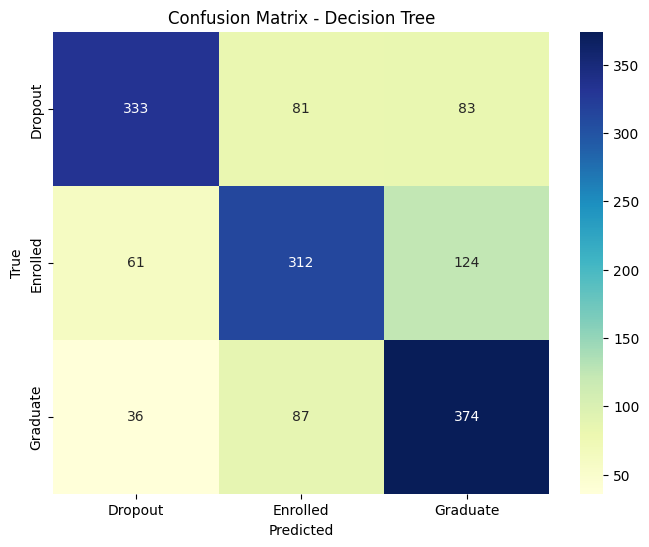

In [37]:
# Decision Tree evaluation
evaluating(y_train_enc, y_pred_dt_enc, labels=label_encoder.classes_, model_name="Decision Tree")


===== Random Forest Evaluation =====
              precision    recall  f1-score   support

     Dropout       0.81      0.93      0.87       436
    Enrolled       0.89      0.82      0.85       537
    Graduate       0.87      0.84      0.86       518

    accuracy                           0.86      1491
   macro avg       0.86      0.86      0.86      1491
weighted avg       0.86      0.86      0.86      1491



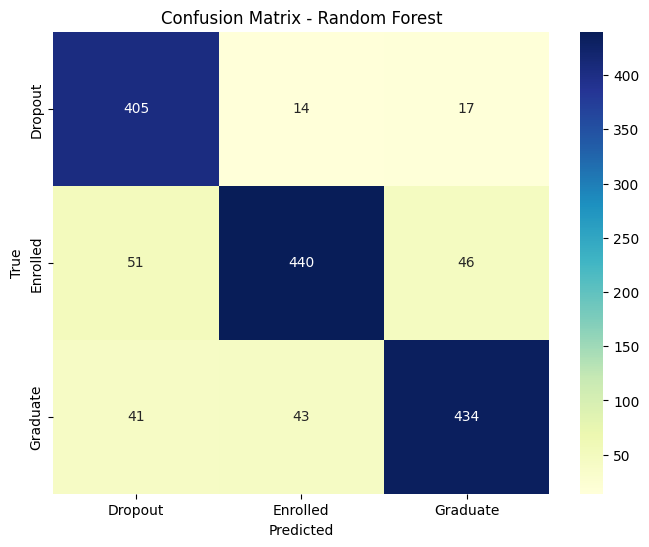

In [38]:
# Random Forest evaluation
evaluating(y_pred_rf_enc, y_train_enc, labels=["Dropout", "Enrolled", "Graduate"], model_name="Random Forest")

In [39]:
# save model, label dan pca
joblib.dump(pipeline, 'rf_best_model.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')
joblib.dump(pca1, 'pca_model.pkl')

['pca_model.pkl']

In [40]:
# List of original feature names before PCA (in X_train_scaled order)
original_features = [col.lower() for col in categorical_cols if col.lower() != 'status']

# Take the loading matrix from PCA
pca1_components = pca1.components_  # shape: (5, num_features)
pca1_matrix = pca1_components.T     # transpose -> shape: (num_features, 5)

pc_df = pd.DataFrame(pca1_matrix, columns=[f'PC{i+1}' for i in range(pca1_matrix.shape[1])], index=original_features)

# Calculate the absolute contribution to PC1
pc_df['PC1_abs'] = pc_df['PC1'].abs()
pc_df_sorted_pc1 = pc_df.sort_values(by='PC1_abs', ascending=False)

print("Kontribusi fitur ke PC1:")
print(pc_df_sorted_pc1[['PC1']])

# Calculate the total absolute contribution to all PCs (PC1-5)
pc_df['total_abs'] = pc_df[[f'PC{i+1}' for i in range(5)]].abs().sum(axis=1)
pc_df_sorted_total = pc_df.sort_values(by='total_abs', ascending=False)

print("\nTotal kontribusi fitur terhadap semua komponen PCA:")
print(pc_df_sorted_total[['total_abs']])

Kontribusi fitur ke PC1:
                                 PC1
displaced                   0.703647
gender                     -0.491839
application_mode           -0.280065
scholarship_holder          0.236389
daytime_evening_attendance  0.207497
tuition_fees_up_to_date     0.171121
previous_qualification     -0.156699
debtor                     -0.148959
course                      0.061552
mothers_qualification      -0.055559
marital_status             -0.050627
mothers_occupation         -0.008829
educational_special_needs   0.004882
fathers_qualification      -0.004469
fathers_occupation          0.003965
nacionality                 0.001388
international              -0.000175

Total kontribusi fitur terhadap semua komponen PCA:
                            total_abs
scholarship_holder           1.932995
displaced                    1.879074
gender                       1.791300
debtor                       1.405681
fathers_qualification        1.272689
tuition_fees_up_to_date     

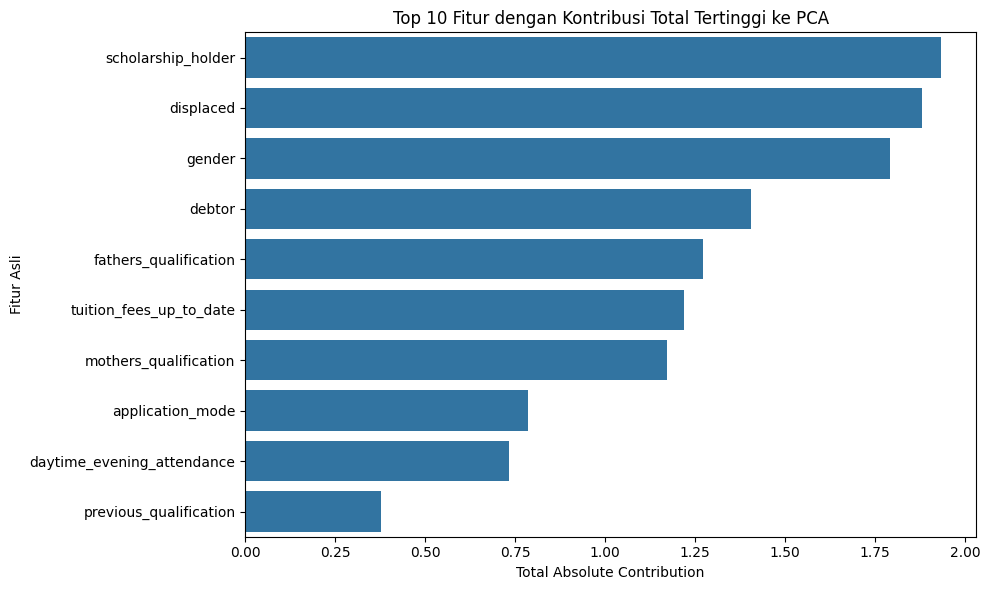

In [41]:
# Visualization of total feature contribution to PCA
plt.figure(figsize=(10, 6))
sns.barplot(
    x=pc_df_sorted_total['total_abs'].head(10),
    y=pc_df_sorted_total.head(10).index
)
plt.title("Top 10 Fitur dengan Kontribusi Total Tertinggi ke PCA")
plt.xlabel("Total Absolute Contribution")
plt.ylabel("Fitur Asli")
plt.tight_layout()
plt.show()

## Pertanyaan Bisnis & Jawaban
1. Berapa proporsi mahasiswa yang keluar (drop out) dibandingkan total mahasiswa?
  - International Student :
    - 32,27% Dropout
    - 17,57% Enrolled
    - 50,16% Graduate
  - Domestic student :
    - 31,52% Dropout
    - 23,91% Enrolled
    - 44,57% Graduate

2. Bagaimana distribusi status mahasiswa berdasarkan berbagai fitur

  Dari berbagai grafik bar dan boxplot:
  - **Beasiswa :** Mahasiswa yg menerima beasiswa cenderung memiliki tingkat dropout lebih tinggi daripada yg tidak meneirma beasiswa
  - **Jenis Kelamin:** Mahasiswa laki-laki cenderung memiliki tingkat dropout lebih tinggi dibanding perempuan.
  
  - **Umur saat masuk kuliah:** Umur lebih muda cenderung memiliki tingkat kelulusan yang lebih tinggi.
  
  - **Status Pernikahan:** Mahasiswa lajang mendominasi seluruh kategori, tetapi pernikahan tampaknya tidak signifikan memengaruhi status
  
  - **Pekerjaan & Pendidikan orang tua:** Mahasiswa dengan orang tua berpendidikan lebih tinggi atau bekerja dalam posisi profesional cenderung memiliki tingkat kelulusan lebih baik.
  
  - **Kredit & evaluasi semester:** Mahasiswa yang mengambil dan menyelesaikan lebih banyak mata kuliah semester 1 dan 2 memiliki kemungkinan lulus yang jauh lebih tinggi.
  
  - **Grade penerimaan (Admission Grade):** Semakin tinggi admission grade, semakin besar peluang untuk lulus.
  
  - **Faktor ekonomi (GDP, Pengangguran, Inflasi):** Korelasi kecil tapi terlihat bahwa lingkungan ekonomi yang lebih baik mendukung tingkat kelulusan lebih tinggi.

  3. Faktor yang paling mempengaruhi kelulusan/dropout mahasiswa?
  
    Berdasarkan PCA
    - Scholarship_holder
    - Displaced        
    - Gender                      
    - Debtor             
    - Tuition_fees_up_to_date    
    - mothers_qualification
    - fathers_qualification           
    - dst

# Kesimpulan
1. Secara keseluruhan, tingkat dropout mahasiswa, baik internasional maupun domestik, cukup tinggi, dan status kelulusan sangat dipengaruhi oleh berbagai faktor.
2. Faktor-faktor yg menjadi pemicu mahasiswa dropout dapat dilihat melalui hasil analisis PCA yang meliputi
  - Perbandingan mahasiswa yg tidak menerima beasiswa cenderung memiliki tingkat dropout lebih tinggi daripada yg tidak meneirma beasiswa
  - Mahasiswa yg terlantar cenderung memiliki tingkat dropout lebih tinggi
  - Mahasiswa laki-laki cenderung memiliki tingkat dropout lebih tinggi dibanding perempuan.
  - Keluarga mahasiswa yang memiliki pinjaman cenderung memiliki tingkat dropout yang tinggi
  - Masalah biaya pendidikan menunggak juga menjadi salah satu faktor penting

3. Pipeline data preprocessing dan model prediktif menggunakan Random Forest telah di-otomatisasi menggunakan Spark ML. Model ini memungkinkan integrasi ke dalam sistem operasional institusi untuk memantau status setiap siswa secara langsung dan mengeluarkan peringatan dini bila probabilitas dropout melewati ambang batas.

# Action Items
1. **Perkuat dukungan akademik di semester awal**
Banyak mahasiswa gagal di semester awal. Fokuskan bimbingan dan monitoring intensif pada semester 1 dan 2.

2. **Bantu mahasiswa dengan kesulitan keuangan**
Fitur Debtor dan Tuition_fees_up_to_date sangat memengaruhi kelulusan. Tawarkan program bantuan keuangan atau beasiswa.

3. **Pantau dan evaluasi mahasiswa dengan latar belakang kurang mampu**
Mahasiswa dengan orang tua dengan pendidikan rendah atau pendapatan rendah memerlukan perhatian tambahan.

4. **Fasilitasi pembelajaran yang mendukung penyelesaian mata kuliah**
Mahasiswa yang menyelesaikan lebih banyak mata kuliah punya peluang lulus lebih besar. Dorong partisipasi dan hindari "tidak hadir ujian".